In [0]:
! wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1CLVhkMfwJxeUit4qhkUsQWMu8rYHaAMr' -O dataset.zip
! unzip dataset.zip

--2020-03-26 18:02:58--  https://docs.google.com/uc?export=download&id=1CLVhkMfwJxeUit4qhkUsQWMu8rYHaAMr
Resolving docs.google.com (docs.google.com)... 172.217.203.101, 172.217.203.138, 172.217.203.100, ...
Connecting to docs.google.com (docs.google.com)|172.217.203.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-60-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/l6ruqsataa0vg6j609k4996tcnkqj20v/1585245750000/13276502723108987596/*/1CLVhkMfwJxeUit4qhkUsQWMu8rYHaAMr?e=download [following]
--2020-03-26 18:02:59--  https://doc-10-60-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/l6ruqsataa0vg6j609k4996tcnkqj20v/1585245750000/13276502723108987596/*/1CLVhkMfwJxeUit4qhkUsQWMu8rYHaAMr?e=download
Resolving doc-10-60-docs.googleusercontent.com (doc-10-60-docs.googleusercontent.com)... 172.217.193.132, 2607:f8b0:400c:c03::84
Connecting to doc-10-60-docs.googleusercontent.com (doc-10

In [0]:
! mkdir tens fifty hundred
! cp Dataset/*_10_* tens
! cp Dataset/*_50_* fifty
! cp Dataset/*_100_* hundred

In [0]:
! ls tens/

t_10_0.txt  t_10_2.txt	t_10_4.txt  t_10_6.txt	t_10_8.txt
t_10_1.txt  t_10_3.txt	t_10_5.txt  t_10_7.txt	t_10_9.txt


In [0]:
import numpy as np
import os
from pathlib import Path
import math
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
import networkx as nx
import matplotlib.pyplot as plt

In [0]:
def check_symmetric(a, tol=1e-8):
    return np.all(np.abs(a-a.T) < tol)

In [0]:
def normalize_rows(Mat):
    return Mat / np.linalg.norm(Mat, ord=2, axis=1, keepdims=True)

In [0]:
def get_similarity_matrix(folder, index, num_of_nodes):
    pathlist = Path(folder).glob('*.txt')
    files = sorted([str(path) for path in pathlist])
    # print(files)
    A = np.zeros(shape=(num_of_nodes, num_of_nodes))
    noise = 1e-5
    A += noise 
    f = open(files[index])
    lines = f.readlines()
    lines = [l.strip() for l in lines]
    for l in lines:
        assert(len(l.split()) == 3)
        u, v, w = [int(num) for num in l.split()]
        u -= 1
        v -= 1
        A[u][v] += w
        A[v][u] += w
    
    return A

In [0]:
def get_ground_truth():
    lines = []
    with open('Dataset//ground_truth.txt', 'r') as f:
        lines = f.readlines()

    partitions = np.array([np.array([int(val) for val in line[:-1].split(' ')])  for line in lines])

    return partitions

labels = get_ground_truth()

In [0]:
def get_degree_matrix(A):
    n = len(A)
    Delta = np.zeros(shape=(n, n))
    for i in range(n):
        Delta[i][i] = np.sum(A[i])
    return Delta

In [0]:
def get_B(SimMat, DegMat):
    L = DegMat - SimMat
    Deg_inv = np.linalg.pinv(DegMat)
    return Deg_inv.dot(L)

In [0]:
def build_contingency_table(labels, true_labels):
    assert(labels.shape == true_labels.shape)
    n_clusters = np.amax(labels) + 1
    n_partitions = np.amax(true_labels) + 1
    dims = (n_clusters , n_partitions)
    cont_tab = np.zeros(shape=dims)
    for i in range(len(labels)):
        ci = labels[i]
        pi = true_labels[i]
        cont_tab[ci][pi] += 1 #this point is in common between the cluster and the partition
    return cont_tab

In [0]:
def spectral_clustering(SimMat, DegMat, k):
    B = get_B(SimMat, DegMat)
    eigvals, eigvecs = np.linalg.eigh(B)
    U = eigvecs.T[:k].T
    norm = True
    Y = None

    if norm:
        Y = normalize_rows(U)
    else:
        Y = U
    
    kmeans = KMeans(n_clusters=k, random_state=0).fit(Y)
    return kmeans.labels_

In [0]:
def cond_entropy(contingency_tab, labels, ground_truth):
    assert(labels.shape == ground_truth.shape)
    r = np.max(labels) + 1 # number of clusters
    k = np.amax(ground_truth) + 1 #number of partitions
    cluster_sizes = [0] * r # sizes of clusters Ci (ni)
    partition_sizes = [0] * k  # sizes of partitions Tj(mj)  
    n = num_of_points = len(labels)

    for ci in labels:
        cluster_sizes[ci] += 1
    for tj in ground_truth:
        partition_sizes[tj] += 1

    h_t_c = 0

    for i in range(r):
        ni = cluster_sizes[i]
        for j in range(k):
            n_i_j = contingency_tab[i][j]
            p = n_i_j /ni
            if p != 0:
                h_t_c -= n_i_j/n *np.log2(p)
    return h_t_c

In [0]:
def compute_traffic(mat, labels, noise=0):
    n, n = np.shape(mat)
    internal_traffic = np.zeros(np.max(labels) +1)
    external_traffic = np.zeros(np.max(labels)+1)
    for i in range(n): # iterate on elements below main diagonal
        for j in range(i):
            w = mat[i][j]

            if w <= noise: #ignore noise
                continue

            if labels[i] == labels[j]: # if they have same label then they are in the same cluster
                cluster_num = labels[i]
                #add weight of edge to the internal traffic of the cluster
                internal_traffic[cluster_num] += w
            else:
                #not in same cluster, so add the weight of the edge to external traffic 
                external_traffic[labels[i]] += w
                external_traffic[labels[j]] += w
    
    return internal_traffic, external_traffic

In [0]:
def get_distance_matrix(mat, noise=0):
    dims = np.shape(mat)
    dist_mat = np.ones(dims)
    n = len(mat)
    for i in range(n):
        for j in range(i):
            w = mat[i][j]
            if w>= noise:
                dist_mat[i][j] = dist_mat[j][i] = np.exp(-0.01* w)
    
    return dist_mat

In [0]:
def normalized_cut_measure(weight_mat, labels, noise=0):
    #1. convert weight matrix to distance matrix e^-0.01w
    dist = get_distance_matrix(weight_mat,noise= noise)
    #2 get internal distances within cluster, and among clusters
    internal_dist, external_dist = compute_traffic(dist, labels, noise=noise)

    NC = 0
    for i in range(len(internal_dist)):
        NC +=  external_dist[i]/(external_dist[i] + internal_dist[i])
    
    return NC

In [0]:
def f_measure_onerow(cont_mat, row : int):
    arr = cont_mat[row]
    max_val = np.amax(arr)
    index = np.where(arr == max_val)[0][0]
    ret = (2 * cont_mat[row][index]) / (np.sum(cont_mat[row]) + np.sum(cont_mat[ : , index]))
    # print('row', row, ret)
    return ret

In [0]:
def f_measure(cont_table):
    r = cont_table.shape[0]
    return (1.0 / r) * (np.sum([f_measure_onerow(cont_table, i) for i in range(r)]))

In [0]:
# for visualizing graph
def draw_graph(A, clusters=None, title='' ,noise=0):
    G =nx.Graph()
    n, n = np.shape(A)
    for i in range(n):
        for j in range(i): #works as long as entrys a[i][i] are empty!
            #print(str(i) +' ,' + str(j) )
            if A[i][j] > noise:
                G.add_edge(i+1,j+1, weight = A[i][j])
            else:# add node if it doesnt exist
                G.add_node(i+1)
                
    pos = nx.spring_layout(G)
    #pos = nx.
    plt.figure()
    plt.axis('off')
    if clusters : 
        colors =[clusters[i-1] for i in G.nodes  ]
        nx.draw(G,pos=pos, node_color=colors, with_labels = True)
    else:
        nx.draw(G,pos=pos, with_labels= True)
    labels = nx.get_edge_attributes(G,'weight')# get weights
    nx.draw_networkx_edge_labels(G,pos, edge_labels=labels)# draw weights on edges
    plt.title(title)
    plt.show()

In [0]:
folder_names = ['tens', 'fifty', 'hundred']
sizes = [10, 50, 100]
kvals_10 = [2, 4, 6, 8, 10]
kvals_50_100 = [2,10,12,15,17,20,25]

In [0]:
# Clustering and Evaluation
def run():
    true_labels_row = 0
    for i in range(30):
        now = i // 10
        folder_name = folder_names[now]
        num_of_nodes = sizes[now]
        kvals = None
        if i < 10:
            kvals = kvals_10
        else:
            kvals = kvals_50_100

        SimilarityMatrix = get_similarity_matrix(folder=folder_name, index=true_labels_row % 10, num_of_nodes=num_of_nodes)
        DegreeMatrix = get_degree_matrix(SimilarityMatrix)
        
        for n_clusters in kvals:
            print()
            k_means_labels = spectral_clustering(SimilarityMatrix, DegreeMatrix, n_clusters)
            true_labels = labels
            n = len(DegreeMatrix)
            
            if n == 100:
                print(f'Size : {n}, test : {i % 10} K : {n_clusters} normalized cut {normalized_cut_measure(SimilarityMatrix, k_means_labels)}')
            else:
                cont_table = build_contingency_table(k_means_labels, true_labels[true_labels_row])
                ce = cond_entropy(cont_table, k_means_labels, true_labels[true_labels_row])
                print(f'Size : {n}, test : {i % 10} K : {n_clusters} Cond entropy  : {ce} , F-measure : {f_measure(cont_table)}')
                if num_of_nodes == 10:
                    print('our labels : ', k_means_labels)
                    print('ground truth: ', true_labels[true_labels_row])
            internal_traffic, external_traffic = compute_traffic(SimilarityMatrix, k_means_labels, noise = 1e-5)
            print('internal traffic = ', internal_traffic)
            print('external traffic = ', external_traffic)
        true_labels_row += 1

        print()
run()


Size : 10, test : 0 K : 2 Cond entropy  : 2.1219280948873624 , F-measure : 0.39285714285714285
our labels :  [1 0 0 0 1 1 0 1 0 1]
ground truth:  [ 2  1 20  2  4  0  3  3  0  2]
internal traffic =  [4792.00006 3392.00006]
external traffic =  [2318.00006 2318.00006]

Size : 10, test : 0 K : 4 Cond entropy  : 1.3509775004326943 , F-measure : 0.44999999999999996
our labels :  [3 0 3 0 1 2 0 1 1 2]
ground truth:  [ 2  1 20  2  4  0  3  3  0  2]
internal traffic =  [2636.00003 1505.00003  929.00001    0.     ]
external traffic =  [3001.00006 5216.00009 2351.00006  296.00001]

Size : 10, test : 0 K : 6 Cond entropy  : 0.8754887502163469 , F-measure : 0.5777777777777777
our labels :  [4 1 5 0 1 3 0 2 1 3]
ground truth:  [ 2  1 20  2  4  0  3  3  0  2]
internal traffic =  [ 998.00001 2837.00003    0.       929.00001    0.         0.     ]
external traffic =  [2047.00005 4741.0001  2041.00004 2351.00006  296.00001    0.     ]

Size : 10, test : 0 K : 8 Cond entropy  : 0.4 , F-measure : 0.66666

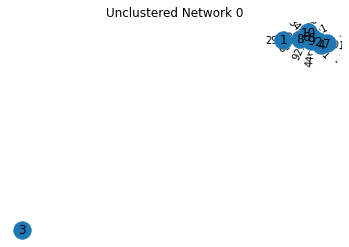

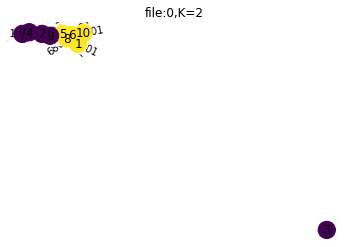

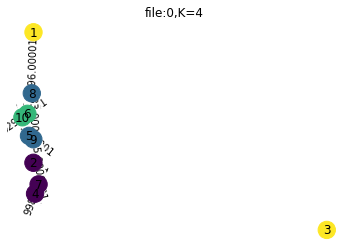

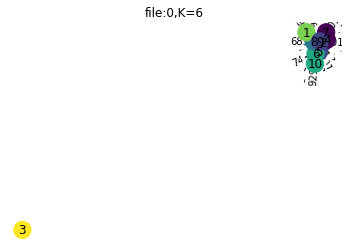

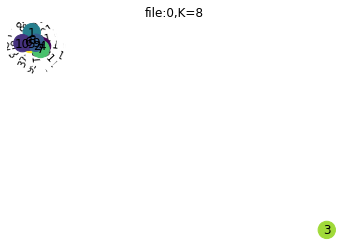

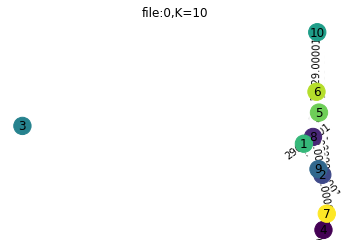

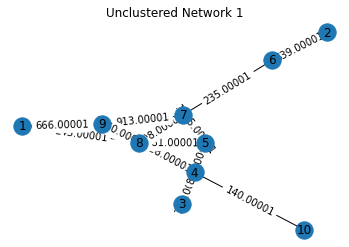

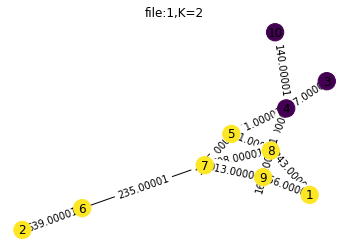

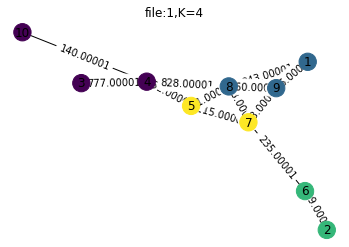

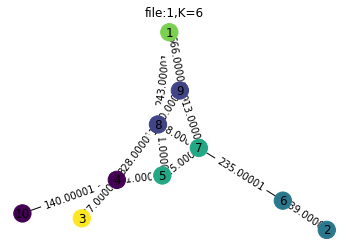

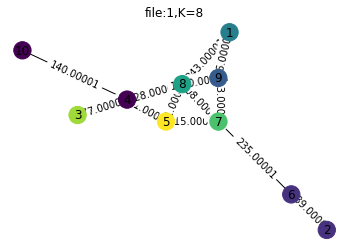

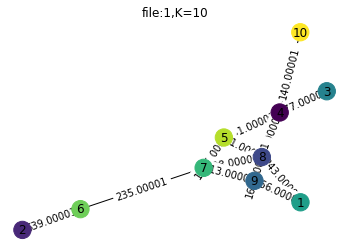

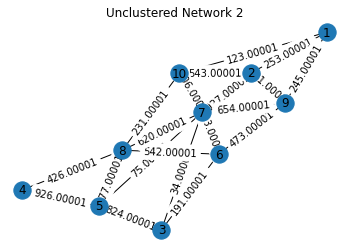

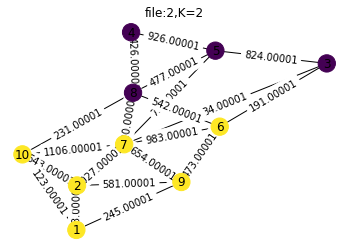

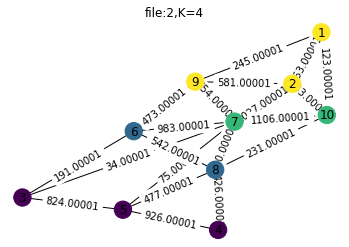

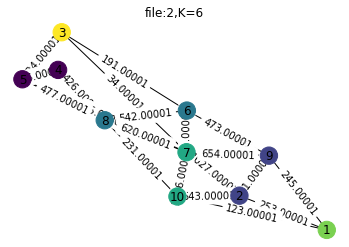

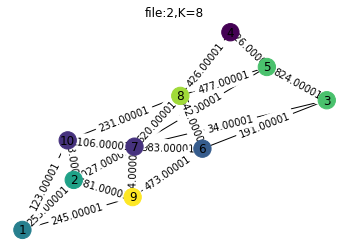

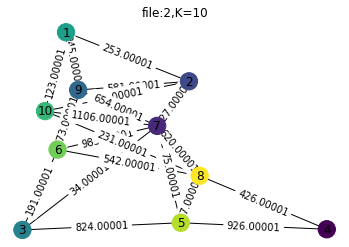

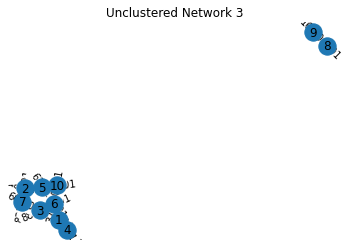

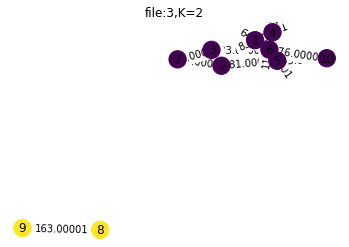

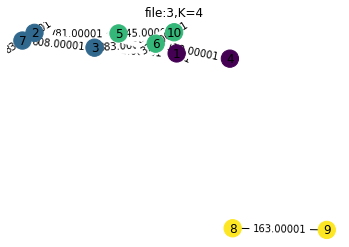

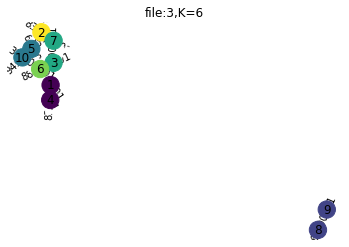

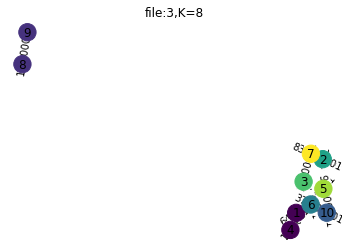

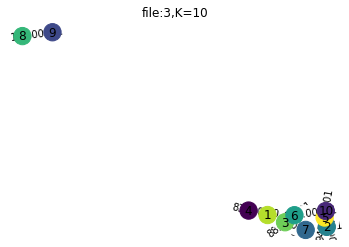

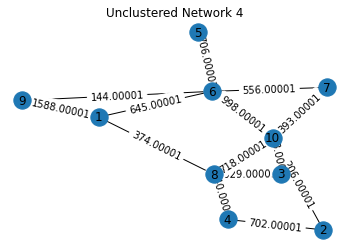

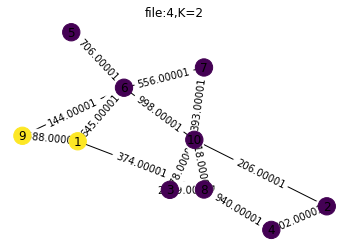

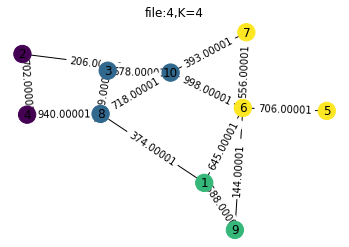

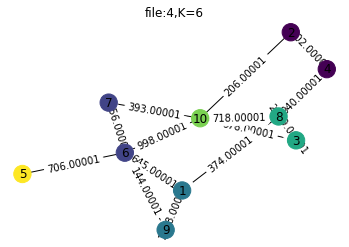

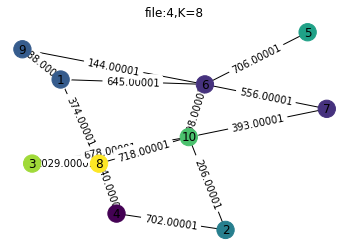

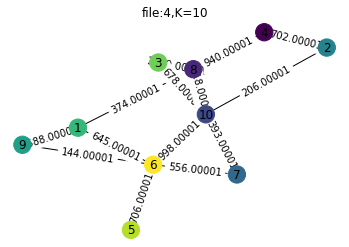

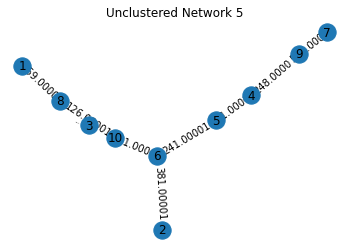

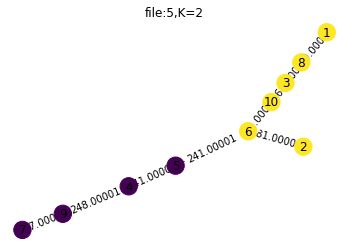

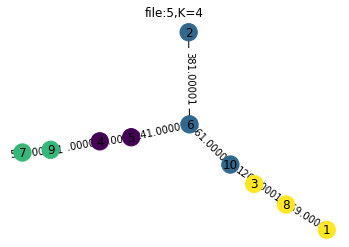

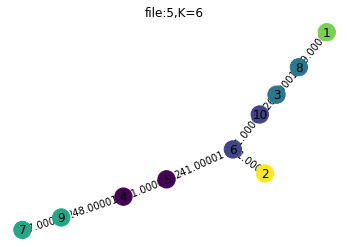

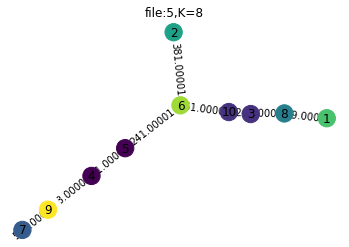

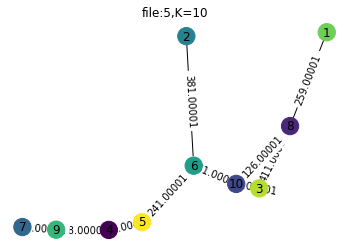

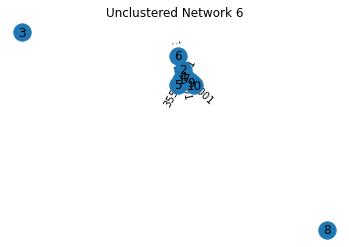

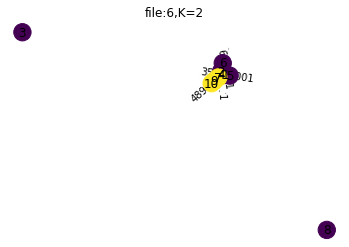

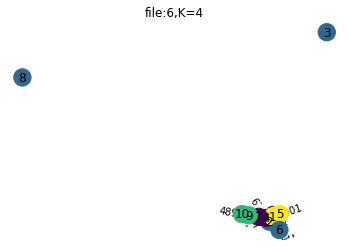

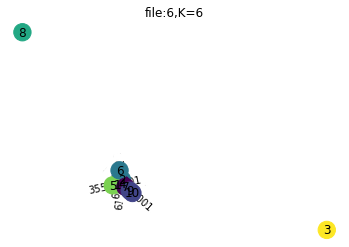

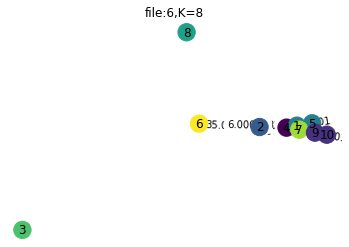

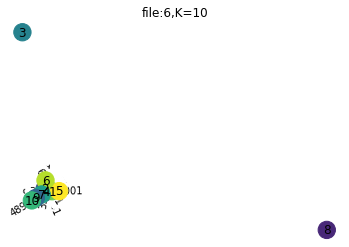

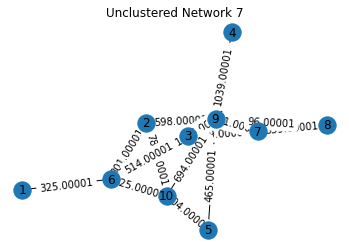

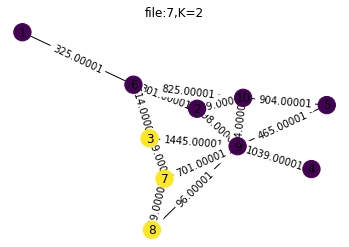

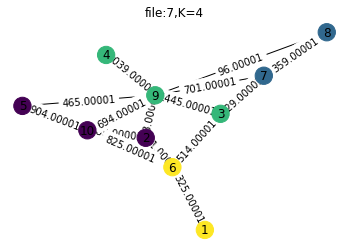

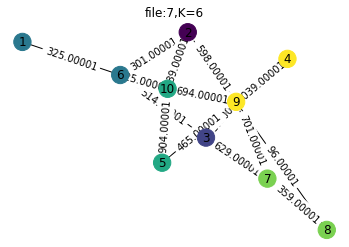

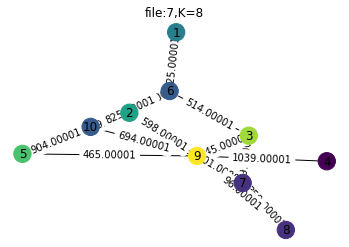

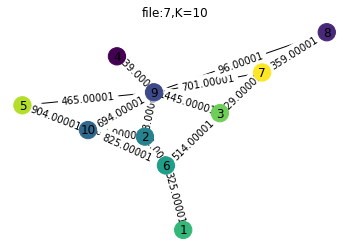

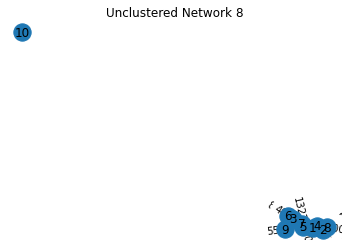

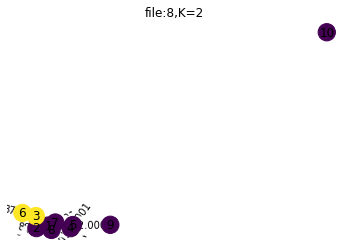

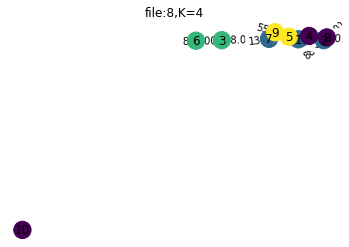

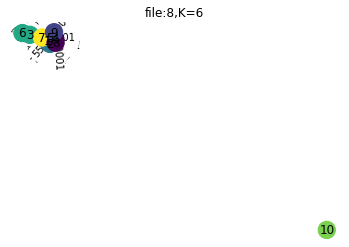

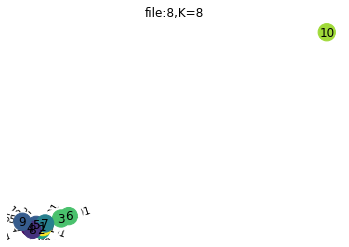

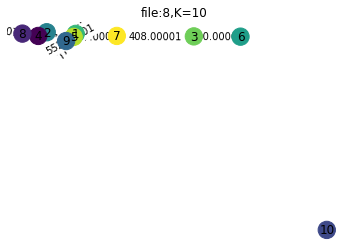

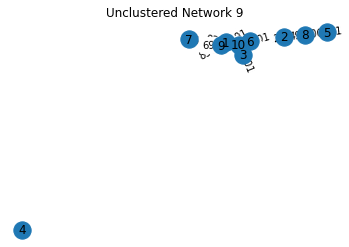

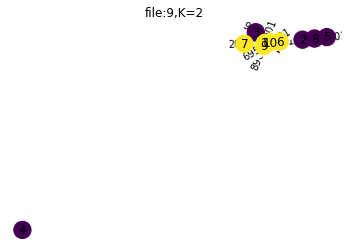

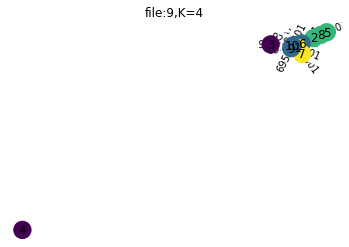

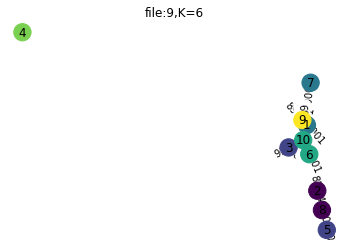

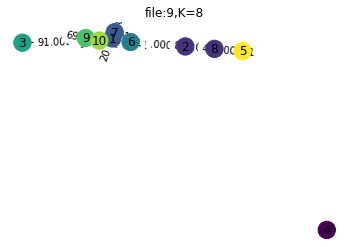

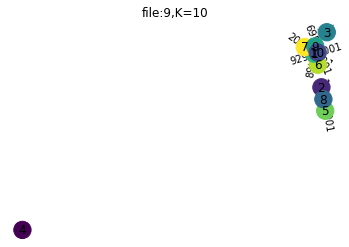

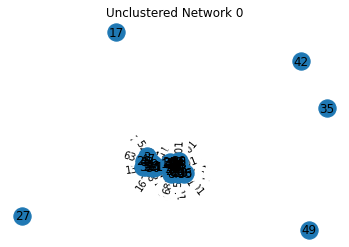

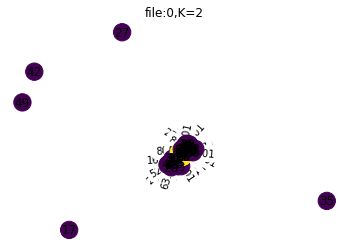

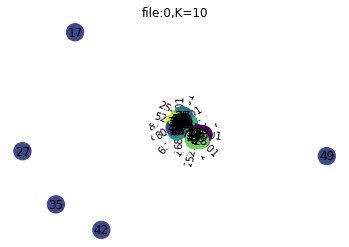

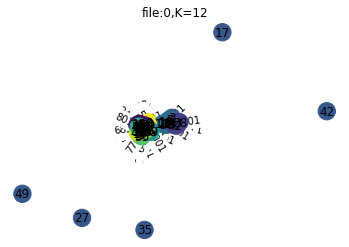

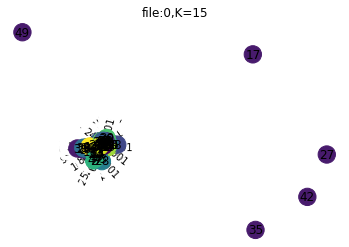

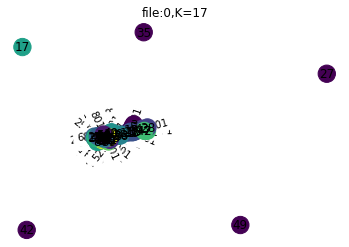

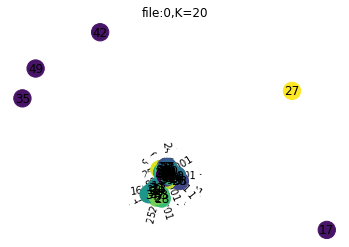

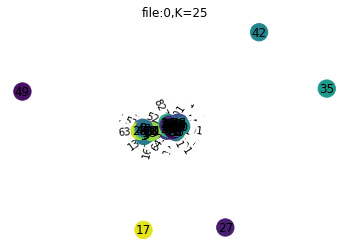

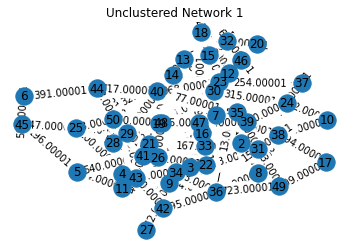

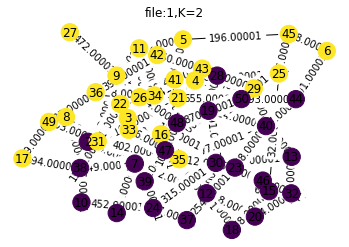

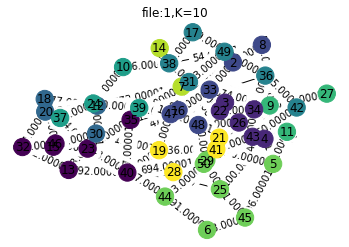

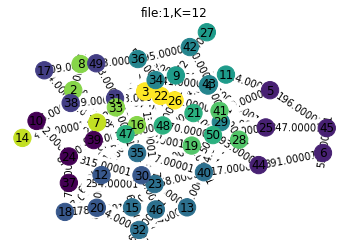

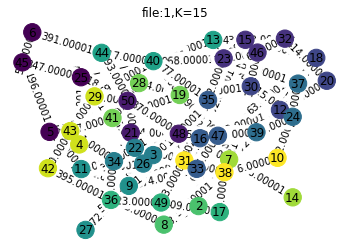

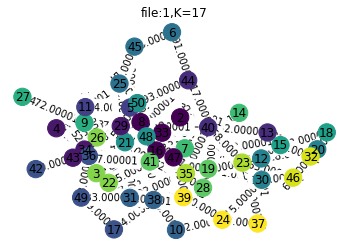

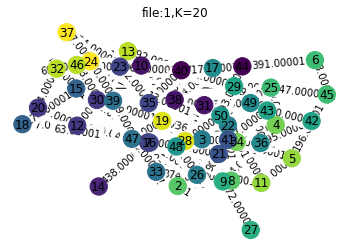

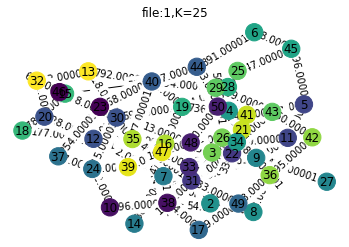

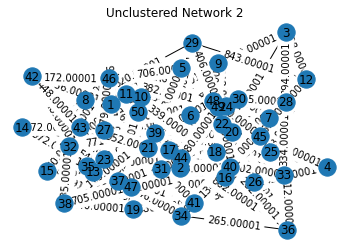

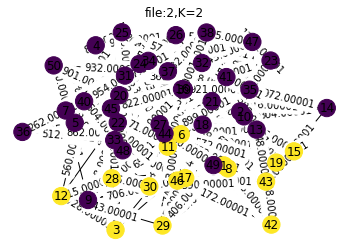

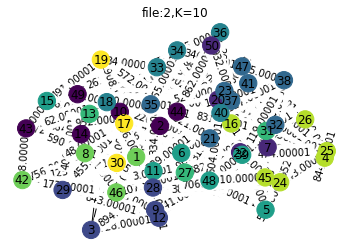

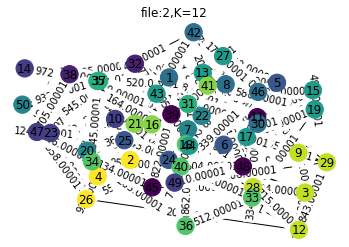

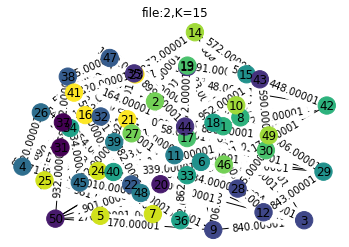

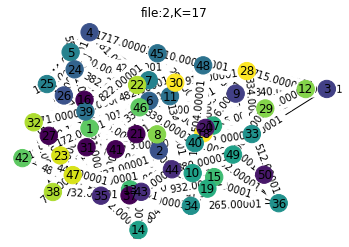

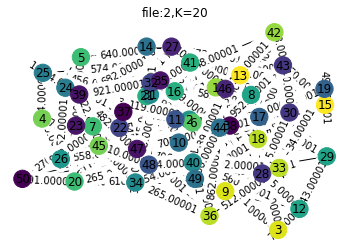

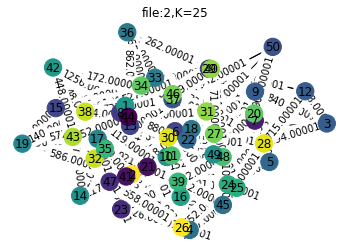

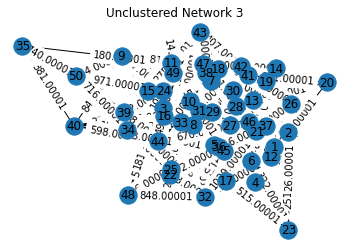

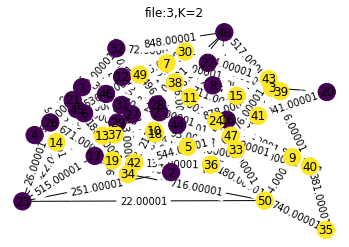

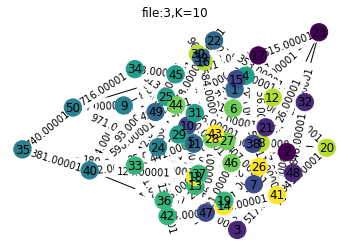

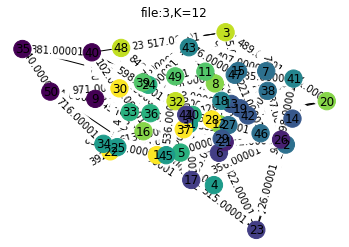

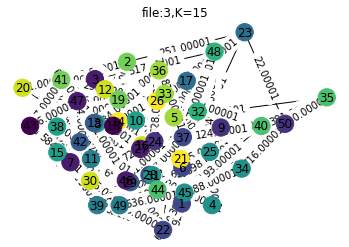

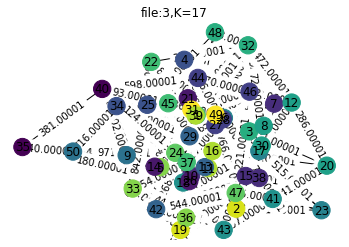

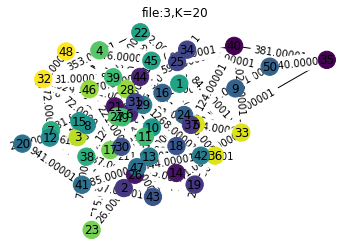

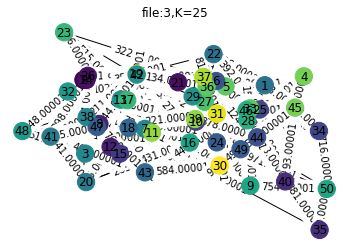

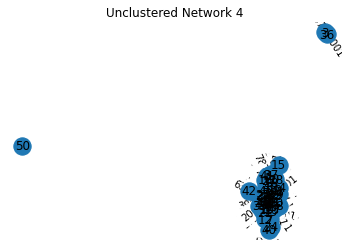

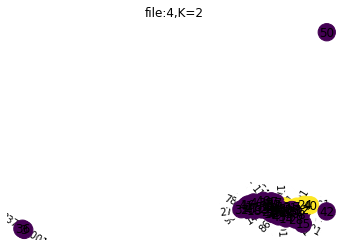

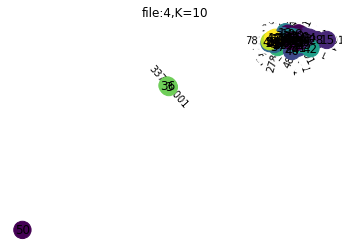

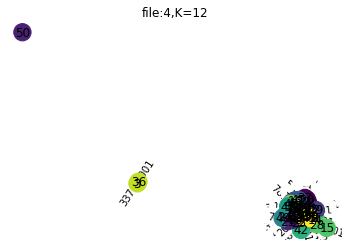

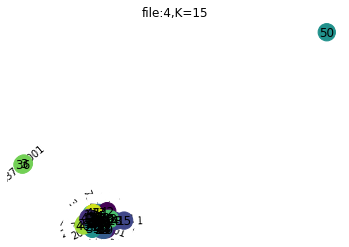

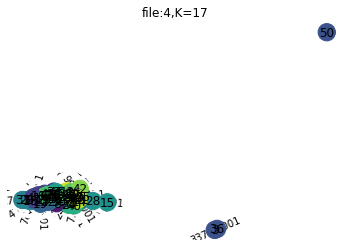

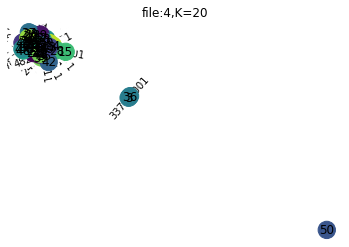

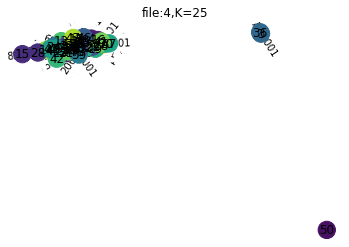

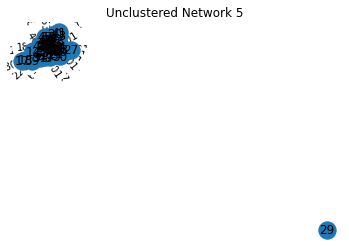

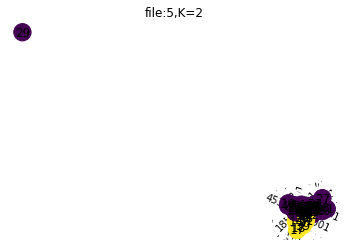

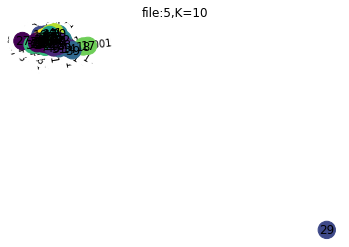

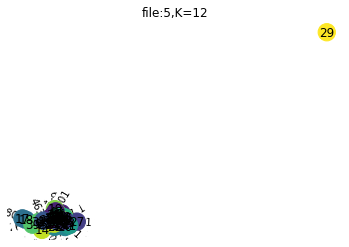

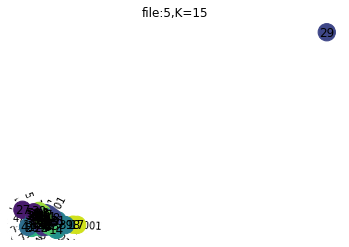

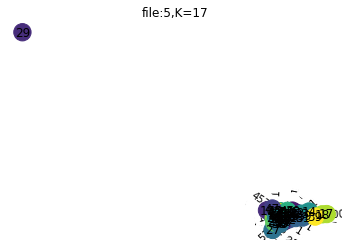

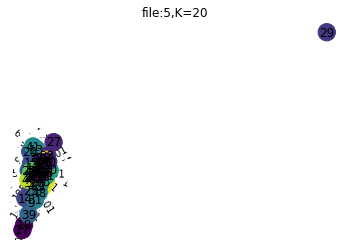

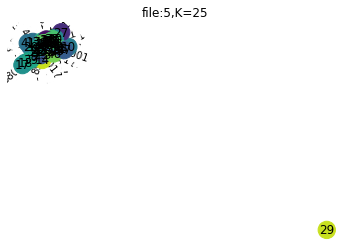

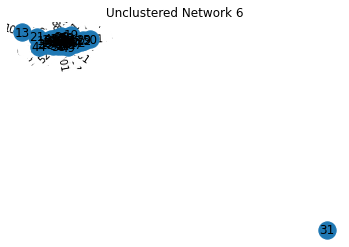

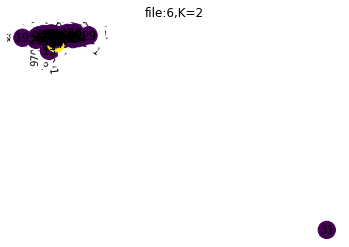

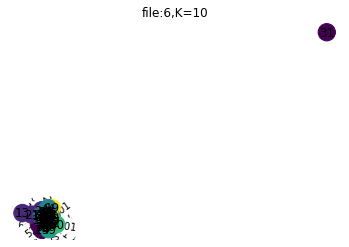

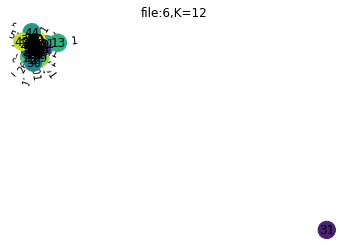

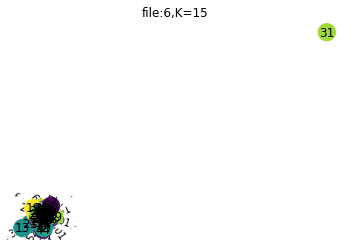

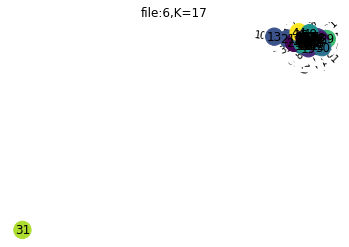

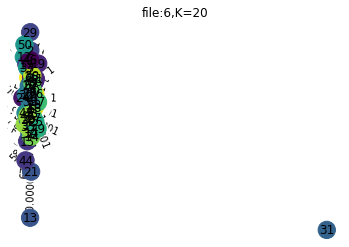

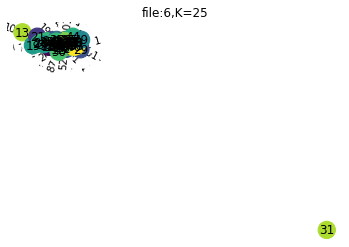

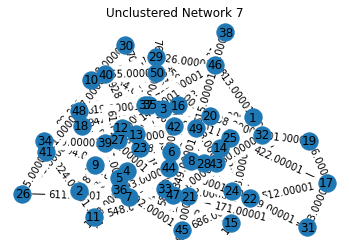

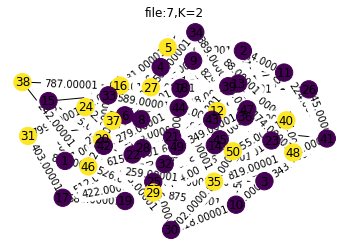

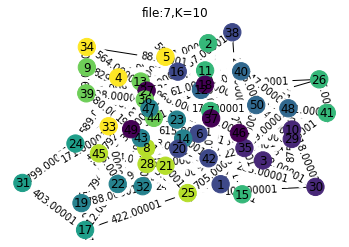

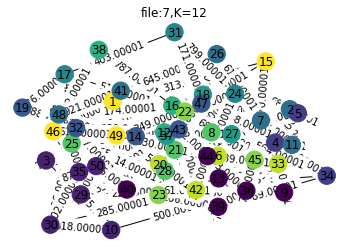

In [0]:
# Visualization
def run():
    true_labels_row = 0
    for i in range(30):
        now = i // 10
        folder_name = folder_names[now]
        num_of_nodes = sizes[now]
        kvals = None
        if i < 10:
            kvals = kvals_10
        else:
            kvals = kvals_50_100


        SimilarityMatrix = get_similarity_matrix(folder=folder_name, index=true_labels_row % 10, num_of_nodes=num_of_nodes)
        DegreeMatrix = get_degree_matrix(SimilarityMatrix)
        draw_graph(SimilarityMatrix, clusters=None, title=f'Unclustered Network {i % 10}', noise = 1e-5)
        for n_clusters in kvals:
            
            k_means_labels = spectral_clustering(SimilarityMatrix, DegreeMatrix, n_clusters)
            true_labels = labels
            n = len(DegreeMatrix)
            title = 'file:{},K={}'.format(i % 10, n_clusters)
            draw_graph(SimilarityMatrix, clusters= list(k_means_labels), title=title, noise = 1e-5)
            
        true_labels_row += 1
    
run()

In [0]:
def get_best_results():
    true_labels_row =
	for i in range(30):
        now = i // 10
        folder_name = folder_names[now]
        num_of_nodes = sizes[now]
        kvals = None
        if i < 10:
            kvals = kvals_10
        else:
            kvals = kvals_50_100
        
        SimilarityMatrix = get_similarity_matrix(folder=folder_name, index=true_labels_row % 10, num_of_nodes=num_of_nodes)\n",
        DegreeMatrix = get_degree_matrix(SimilarityMatrix)\n",
        n = len(DegreeMatrix)\n",
        best_k = 0 # for NC or F measure depending on n\n",
        best_k_entr = 0# k that produces best Entropy\n",
        best_f = -1\n",
        best_entr = 1e10\n",
        best_nc = 1e10\n",
        best_label = None\n",
        best_label_entr = None\n",
        best_int_traff, best_ext_traff = None, None\n",
        best_int_traff_entr, best_ext_traff_entr = None, None\n",
        for n_clusters in kvals:
            k_means_labels = spectral_clustering(SimilarityMatrix, DegreeMatrix, n_clusters)\n",
            true_labels = labels\n",
            if n == 100:\n",
            norm_cut_meas = normalized_cut_measure(SimilarityMatrix, k_means_labels)\n",
            if norm_cut_meas < best_nc: #minimize  NC\n",
                best_k = n_clusters\n",
                best_nc = norm_cut_meas\n",
                best_int_traff, best_ext_traff = compute_traffic(SimilarityMatrix, k_means_labels, noise = 1e-5)\n",
                best_label = k_means_labels\n",
        "                #print(f'Size : {n}, test : {i % 10} K : {n_clusters} normalized cut {norm_cut_meas}')\n",
        "\n",
        "            else:\n",
        "                cont_table = build_contingency_table(k_means_labels, true_labels[true_labels_row])\n",
        "                ce = cond_entropy(cont_table, k_means_labels, true_labels[true_labels_row])\n",
        "                fmeas = f_measure(cont_table)\n",
        "                if fmeas > best_f: #maximize fmeasure\n",
        "                    best_k = n_clusters\n",
        "                    best_f = fmeas\n",
        "                    best_int_traff, best_ext_traff = compute_traffic(SimilarityMatrix, k_means_labels, noise = 1e-5)\n",
        "                    best_label = k_means_labels\n",
        "                if ce < best_entr: #minimize ce\n",
        "                    best_k_entr = n_clusters\n",
        "                    best_entr = ce \n",
        "                    best_int_traff_entr, best_ext_traff_entr = compute_traffic(SimilarityMatrix, k_means_labels, noise = 1e-5)\n",
        "                    best_label_entr = k_means_labels\n",
        "                #print(f'Size : {n}, test : {i % 10} K : {n_clusters} Cond entropy  : {ce} , F-measure : {fmeas}')\n",
        "                #if num_of_nodes == 10:\n",
        "                #    print('our labels : ', k_means_labels)\n",
        "                #    print('ground truth: ', true_labels[true_labels_row])\n",
        "        \n",
        "        draw_graph(SimilarityMatrix, clusters=None, title=f'n={n} Unclustered Network {i % 10}', noise = 1e-5)\n",
        "        if n != 100:\n",
        "            print(f'K = {best_k}  produces best f measure {best_f}(highest) for the the network n={n}, {i%10} ')\n",
        "            print('Spectral Clustering labeling', best_label)\n",
        "            print('ground truth: ', true_labels[true_labels_row])\n",
        "            #print('Internal Traffic due to clustering', best_int_traff)\n",
        "            #print('External Traffic due to clustering', best_ext_traff)\n",
        "            draw_graph(SimilarityMatrix, clusters=list(best_label), title=f'Clustered Network {i % 10} k={best_k} f={best_f}', noise = 1e-5)\n",
        "\n",
        "            print(f'K = {best_k_entr}  produces best conditional Entropy {best_entr}(lowest) for the the network n={n} ,{i%10} ')\n",
        "            print('Spectral Clustering labeling', best_label_entr)\n",
        "            print('ground truth: ', true_labels[true_labels_row])\n",
        "            #print('Internal Traffic due to clustering', best_int_traff_entr)\n",
        "            #print('External Traffic due to clustering', best_ext_traff_entr)\n",
        "            draw_graph(SimilarityMatrix, clusters=list(best_label_entr), title=f'Clustered Network {i % 10} k={best_k_entr} H(T/C)={best_entr}', noise = 1e-5)\n",
        "        else:\n",
        "            print(f'K = {best_k}  produces best normalized cut measure {best_nc}(NC minimum) for the the network n={n}, {i%10} ')\n",
        "            print('Spectral Clustering labeling', best_label)\n",
        "            #print('Internal Traffic due to clustering', best_int_traff)\n",
        "            #print('External Traffic due to clustering', best_ext_traff)\n",
        "            draw_graph(SimilarityMatrix, clusters=list(best_label), title=f'Clustered Network {i % 10} k={best_k} NC={best_nc}', noise = 1e-5)\n",
        "\n",
        "        true_labels_row += 1\n",
\n"
        
        get_best_results()